In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

# Importing Data

This datasets is related to red variants of the Portuguese "Vinho Verde" wine.

##### Input variables (based on physicochemical tests):
* fixed acidity
* volatile acidity
* citric acid
* residual sugar
* chlorides
* free sulfur dioxide
* total sulfur dioxide
* density
* pH
* sulphates
* alcohol
##### Output variable (based on sensory data):
* quality (score between 3 and 8)

In [3]:
data = pd.read_csv("winequality-red.csv")

In [4]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Checking for Missing Data

We do not have missing data in our dataset, we are good to go.

In [5]:
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# Imbalancedness

Our data has imbalancedness problem.

In [6]:
print(data['quality'].value_counts())

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


In [7]:
from sklearn.utils import resample
highest_quality_count = data['quality'].value_counts().max()
oversampled_data = []

for quality in data['quality'].unique():
    quality_data = data[data['quality'] == quality]
    if len(quality_data) < highest_quality_count:
        quality_data = resample(quality_data, 
                                replace=True, 
                                n_samples=highest_quality_count, 
                                random_state=123)
    oversampled_data.append(quality_data)

data_upsampled = pd.concat(oversampled_data)

print(data_upsampled['quality'].value_counts())

quality
5    681
6    681
7    681
4    681
8    681
3    681
Name: count, dtype: int64


In [8]:
Y = data_upsampled["quality"]
X = data_upsampled.drop("quality",axis=1)

# PCA

We reduced our features to 8 dimension and our principle component's are explaining  ~96% of the total variance.

In [9]:
n_comp = 8
X_standard = StandardScaler().fit_transform(X)
pca = PCA(n_components=n_comp)
principalComponents = pca.fit_transform(X_standard)
principalDf = pd.DataFrame(data = principalComponents, columns = [f"pc{i}" for i in range(1,n_comp+1)])

print(f"Explained Variance Ratio: {pca.explained_variance_ratio_.sum()}")

Explained Variance Ratio: 0.9555481995621199


# Train-Test Split

In [10]:
x_train, x_test, y_train, y_test = train_test_split(principalDf, Y, test_size=0.25, random_state=42, stratify=data_upsampled['quality'])

# Model

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)

preds=model.predict(x_test)
score = balanced_accuracy_score(y_test, preds)

print(f"Random Forest Balanced Accuracy: {score:.2f}")

Random Forest Balanced Accuracy: 0.92


In [13]:
cv_scores = cross_val_score(model, principalDf, Y, cv=5, scoring='balanced_accuracy')
print(f"Mean Cross Validation Balanced Accuracy Score: {cv_scores.mean()}")

Mean Cross Validation Balanced Accuracy Score: 0.9113943752683558


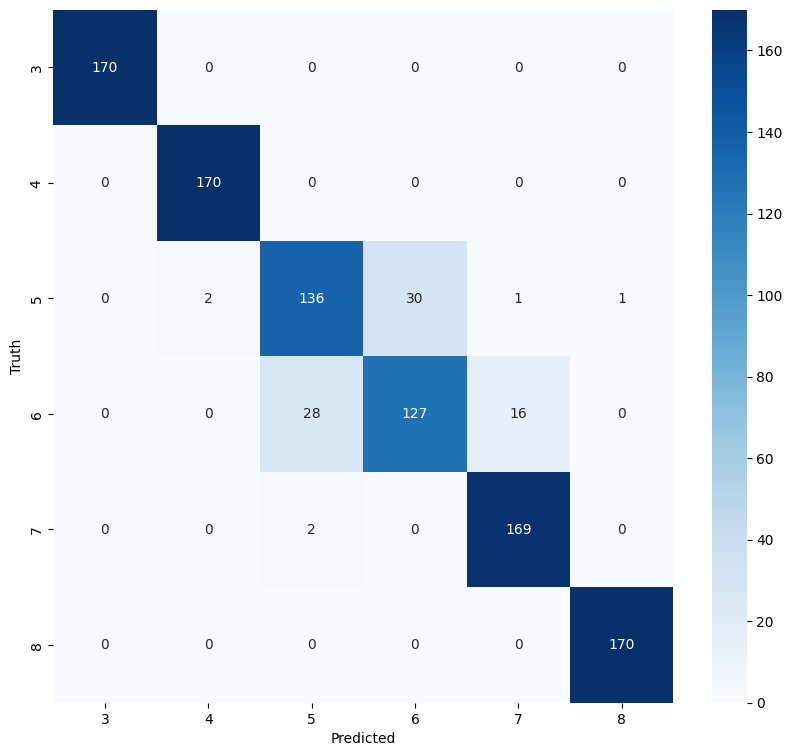

In [85]:
cm = confusion_matrix(y_test, preds, labels=[3,4,5,6,7,8])
plt.figure(figsize=(10,9))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[3,4,5,6,7,8], yticklabels=[3,4,5,6,7,8])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()